In [36]:
import os
import pandas as pd
from glob import glob
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from trustee import ClassificationTrustee
from trustee.report.trust import TrustReport

plt.rcParams['font.family'] = 'sans-serif'

In [37]:
# Base path where all method folders are
METHOD = "pensieve"
base_path = f'./ABR_Separated/{METHOD}/'

# Collect all merged CSVs
all_dfs = []

print("Loading CSV files...")

# Loop through each ABR method folder
path_pattern = os.path.join(base_path, '*.csv')  # Match all CSVs under each method folder
for file_path in glob(path_pattern):
    try:
        df = pd.read_csv(file_path, dtype=str)
        all_dfs.append(df)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

Loading CSV files...


In [38]:
# Combine all data
print("Combining CSVs into one DataFrame...")
data = pd.concat(all_dfs, ignore_index=True)
print(f"Total rows loaded: {len(data)}")

Combining CSVs into one DataFrame...
Total rows loaded: 135498


In [39]:
print(data.columns)

Index(['time (ns GMT)', 'session_id', 'index_x', 'expt_id_x', 'channel_x',
       'video_ts', 'format', 'size', 'ssim_index', 'cwnd', 'in_flight',
       'min_rtt', 'rtt', 'delivery_rate', 'source_dataset_x', 'index_y',
       'expt_id_y', 'channel_y', 'event', 'buffer', 'cum_rebuf',
       'source_dataset_y'],
      dtype='object')


In [40]:
# Drop columns
non_mpc_columns = [
    'time (ns GMT)', 'session_id', 'index_x', 'expt_id_x',
    'channel_x', 'video_ts', 'ssim_index', 'source_dataset_x', 'index_y',
    'expt_id_y', 'channel_y', 'source_dataset_y'
]

data = data.drop(columns=non_mpc_columns)
print(data.columns)

Index(['format', 'size', 'cwnd', 'in_flight', 'min_rtt', 'rtt',
       'delivery_rate', 'event', 'buffer', 'cum_rebuf'],
      dtype='object')


In [41]:
# Rename format_x to PlaybackQuality
data["PlaybackQuality"] = data["format"]
data.drop(columns=['format'], inplace=True)

In [42]:
# Encode event_x labels as integers
event_labels = data["event"].unique()
event_to_index = {q: i for i, q in enumerate(event_labels)}
data['event'] = data['event'].map(event_to_index)

In [43]:
# Convert columns to numeric"
for col in tqdm(data.columns, desc="Converting columns to numeric"):
    if col == 'PlaybackQuality':
        continue
    data[col] = pd.to_numeric(data[col], errors='ignore')

# Drop rows with NaN
data = data.dropna()

print(data.head())

Converting columns to numeric: 100%|████████████| 10/10 [00:00<00:00, 37.73it/s]

     size  cwnd  in_flight  min_rtt    rtt  delivery_rate  event  buffer  \
0   26086    10          0    49313  50802          58889      0   0.000   
1   31592    28          0    48453  51031         394687      0   0.000   
2   27061    55          0    47744  53538         894226      1   0.827   
3  439347    55          0    47744  55859         894226      1   0.827   
4   80630    10          0    85889  89548          31039      1   0.453   

   cum_rebuf PlaybackQuality  
0      0.000      426x240-26  
1      0.000      640x360-24  
2      0.220      640x360-24  
3      0.220    1920x1080-22  
4      0.019      426x240-26  


In [44]:
# Encode labels
le = LabelEncoder()
data['PlaybackQuality'] = le.fit_transform(data['PlaybackQuality'])

# Separate features and labels
X = data.drop(columns=['PlaybackQuality'])
y = data['PlaybackQuality']

In [45]:
# Split
print("Splitting into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
print("Training Random Forest Classifier...")
clf = RandomForestClassifier(n_estimators=10, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

# Evaluate
print("Evaluating model...")
y_pred = clf.predict(X_test)

Splitting into training and test sets...
Training Random Forest Classifier...
Evaluating model...


Classification Report:
              precision    recall  f1-score   support

 1280x720-20       0.93      0.96      0.94      9504
 1280x720-22       0.24      0.08      0.12       266
 1280x720-24       0.38      0.29      0.33       397
 1280x720-26       0.43      0.46      0.44       472
1920x1080-22       0.96      0.97      0.96     14123
1920x1080-24       0.27      0.06      0.10       236
  426x240-26       0.62      0.64      0.63       436
  640x360-24       0.67      0.76      0.71       890
  640x360-26       0.72      0.73      0.72       392
  854x480-22       0.47      0.36      0.41        97
  854x480-24       0.36      0.23      0.28       176
  854x480-26       0.10      0.03      0.04       111

    accuracy                           0.90     27100
   macro avg       0.51      0.46      0.47     27100
weighted avg       0.89      0.90      0.89     27100



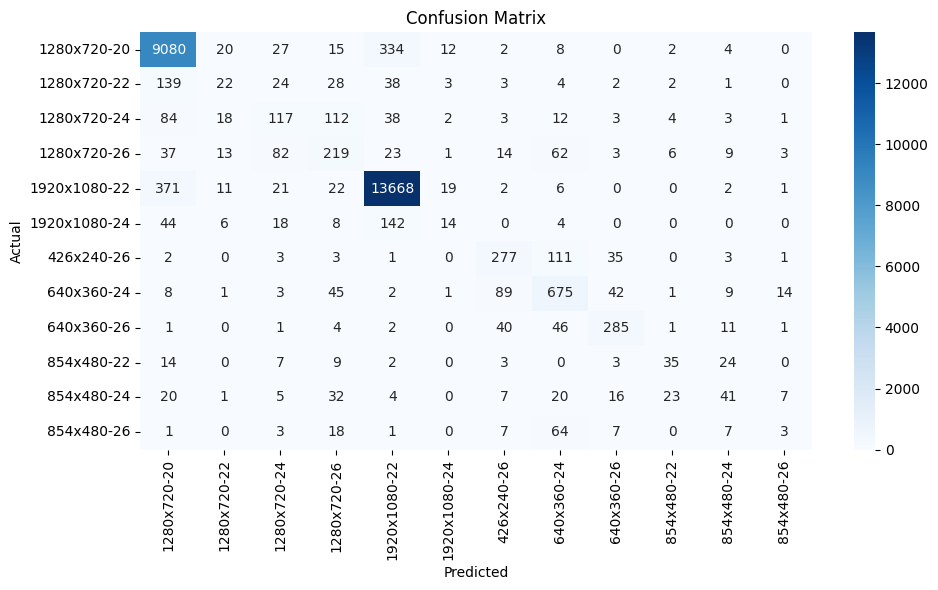

In [46]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# TRUSTEE

In [12]:
importances = clf.feature_importances_
feat_names = X.columns

for name, imp in sorted(zip(feat_names, importances), key=lambda x: -x[1])[:20]:
    print(f"{name}: {imp:.4f}")

cum_rebuf: 0.1975
min_rtt: 0.1938
size: 0.1546
rtt: 0.1418
buffer: 0.1104
cwnd: 0.1015
delivery_rate: 0.0878
in_flight: 0.0100
event: 0.0025


In [13]:
trustee = ClassificationTrustee(expert=clf)
trustee.fit(X_train, y_train, num_iter=50, num_stability_iter=10, samples_size=0.3, verbose=True)
dt, pruned_dt, agreement, reward = trustee.explain()
dt_y_pred = dt.predict(X_test)

print("Fidelity to original model:")
print(classification_report(y_pred, dt_y_pred))

print("Accuracy vs. true labels:")
print(classification_report(y_test, dt_y_pred))

Initializing training dataset using RandomForestClassifier(n_estimators=10, random_state=42) as expert model
Expert model score: 0.9763670844144879
Initializing Trustee outer-loop with 10 iterations
########## Outer-loop Iteration 0/10 ##########
Initializing Trustee inner-loop with 10 iterations
########## Inner-loop Iteration 0/50 ##########
Sampling 20913 points from training dataset with (69713, 69713) entries
Student model 0-0 trained with depth 32 and 2605 leaves:
Student model score: 0.29097672157326754
Student model 0-0 fidelity: 0.29097672157326754
########## Inner-loop Iteration 1/50 ##########
Sampling 20913 points from training dataset with (75987, 75987) entries
Student model 0-1 trained with depth 31 and 2600 leaves:
Student model score: 0.3176024301626927
Student model 0-1 fidelity: 0.3176024301626927
########## Inner-loop Iteration 2/50 ##########
Sampling 20913 points from training dataset with (82261, 82261) entries
Student model 0-2 trained with depth 34 and 2563 lea

/Users/Bryce/anaconda3/envs/trustee/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [ ]:
OUTPUT_PATH = "out"
REPORT_PATH = f"{OUTPUT_PATH}/report/trust_report.obj"

if os.path.exists(REPORT_PATH):
    print(f"Loading trust report from {REPORT_PATH}...")
    trust_report = TrustReport.load(REPORT_PATH)
    print("Done!")
else:
    trust_report = TrustReport(
        blackbox=clf,
        X=X,
        y=y,
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test,
        max_iter=5,
        num_pruning_iter=5,
        train_size=0.7,
        trustee_num_iter=10,
        trustee_num_stability_iter=5,
        trustee_sample_size=0.3,
        analyze_branches=True,
        analyze_stability=True,
        top_k=10,
        verbose=True,
        class_names=list(le.classes_),
        feature_names=list(X.columns),
        is_classify=True,
    )

print(trust_report)
trust_report.save(OUTPUT_PATH)

Loading trust report from out/report/trust_report.obj...
Done!

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                                    Classification Trust Report                                                                                                     |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                       +-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+                        |
|           

# AQUA

In [12]:
concept_dict = {
    'Rebuffering': ['cum_rebuf'],
    'Latency': ['min_rtt', 'rtt'],
    'Network': ['cwnd', 'in_flight', 'delivery_rate'],
    'VideoQuality': ['size'],
    'Buffer': ['buffer'],
    'ClientEvent': ['event'],
}

for concept, features in concept_dict.items():
    concept_dict[concept] = [f for f in features if f in X.columns]

In [13]:
def make_concept_features(X, concept_dict, agg='mean'):
    X_concepts = pd.DataFrame(index=X.index)
    for concept, cols in concept_dict.items():
        valid_cols = [col for col in cols if col in X.columns]
        if not valid_cols:
            continue
        if agg == 'mean':
            X_concepts[concept] = X[valid_cols].mean(axis=1)
        elif agg == 'max':
            X_concepts[concept] = X[valid_cols].max(axis=1)
        elif agg == 'sum':
            X_concepts[concept] = X[valid_cols].sum(axis=1)
    return X_concepts

X_test_concepts = make_concept_features(X_test, concept_dict)

In [14]:
print(X_test_concepts)

        Rebuffering   Latency       Network  VideoQuality  Buffer  ClientEvent
20677         0.079   21774.5  2.394011e+06     2811303.0  14.969          2.0
19111         0.301  154544.5  5.617087e+05     1137104.0  14.758          2.0
60165         0.230   40454.5  2.203238e+06     1781503.0  14.892          2.0
68559         0.402  189033.5  7.385700e+05      701452.0  14.851          2.0
11779         0.151   45685.0  1.918393e+05      135644.0  14.860          2.0
...             ...       ...           ...           ...     ...          ...
131682        0.297   79526.0  2.037463e+06      721241.0  14.970          2.0
9814          0.198   77264.0  2.455613e+05     2227606.0  14.941          2.0
71670         0.402  188724.5  1.225048e+06      912909.0  14.790          2.0
44916         0.298   78016.5  7.907250e+05      337185.0   5.910          2.0
37635         0.427   96792.5  1.356197e+05      136943.0  14.983          2.0

[27100 rows x 6 columns]


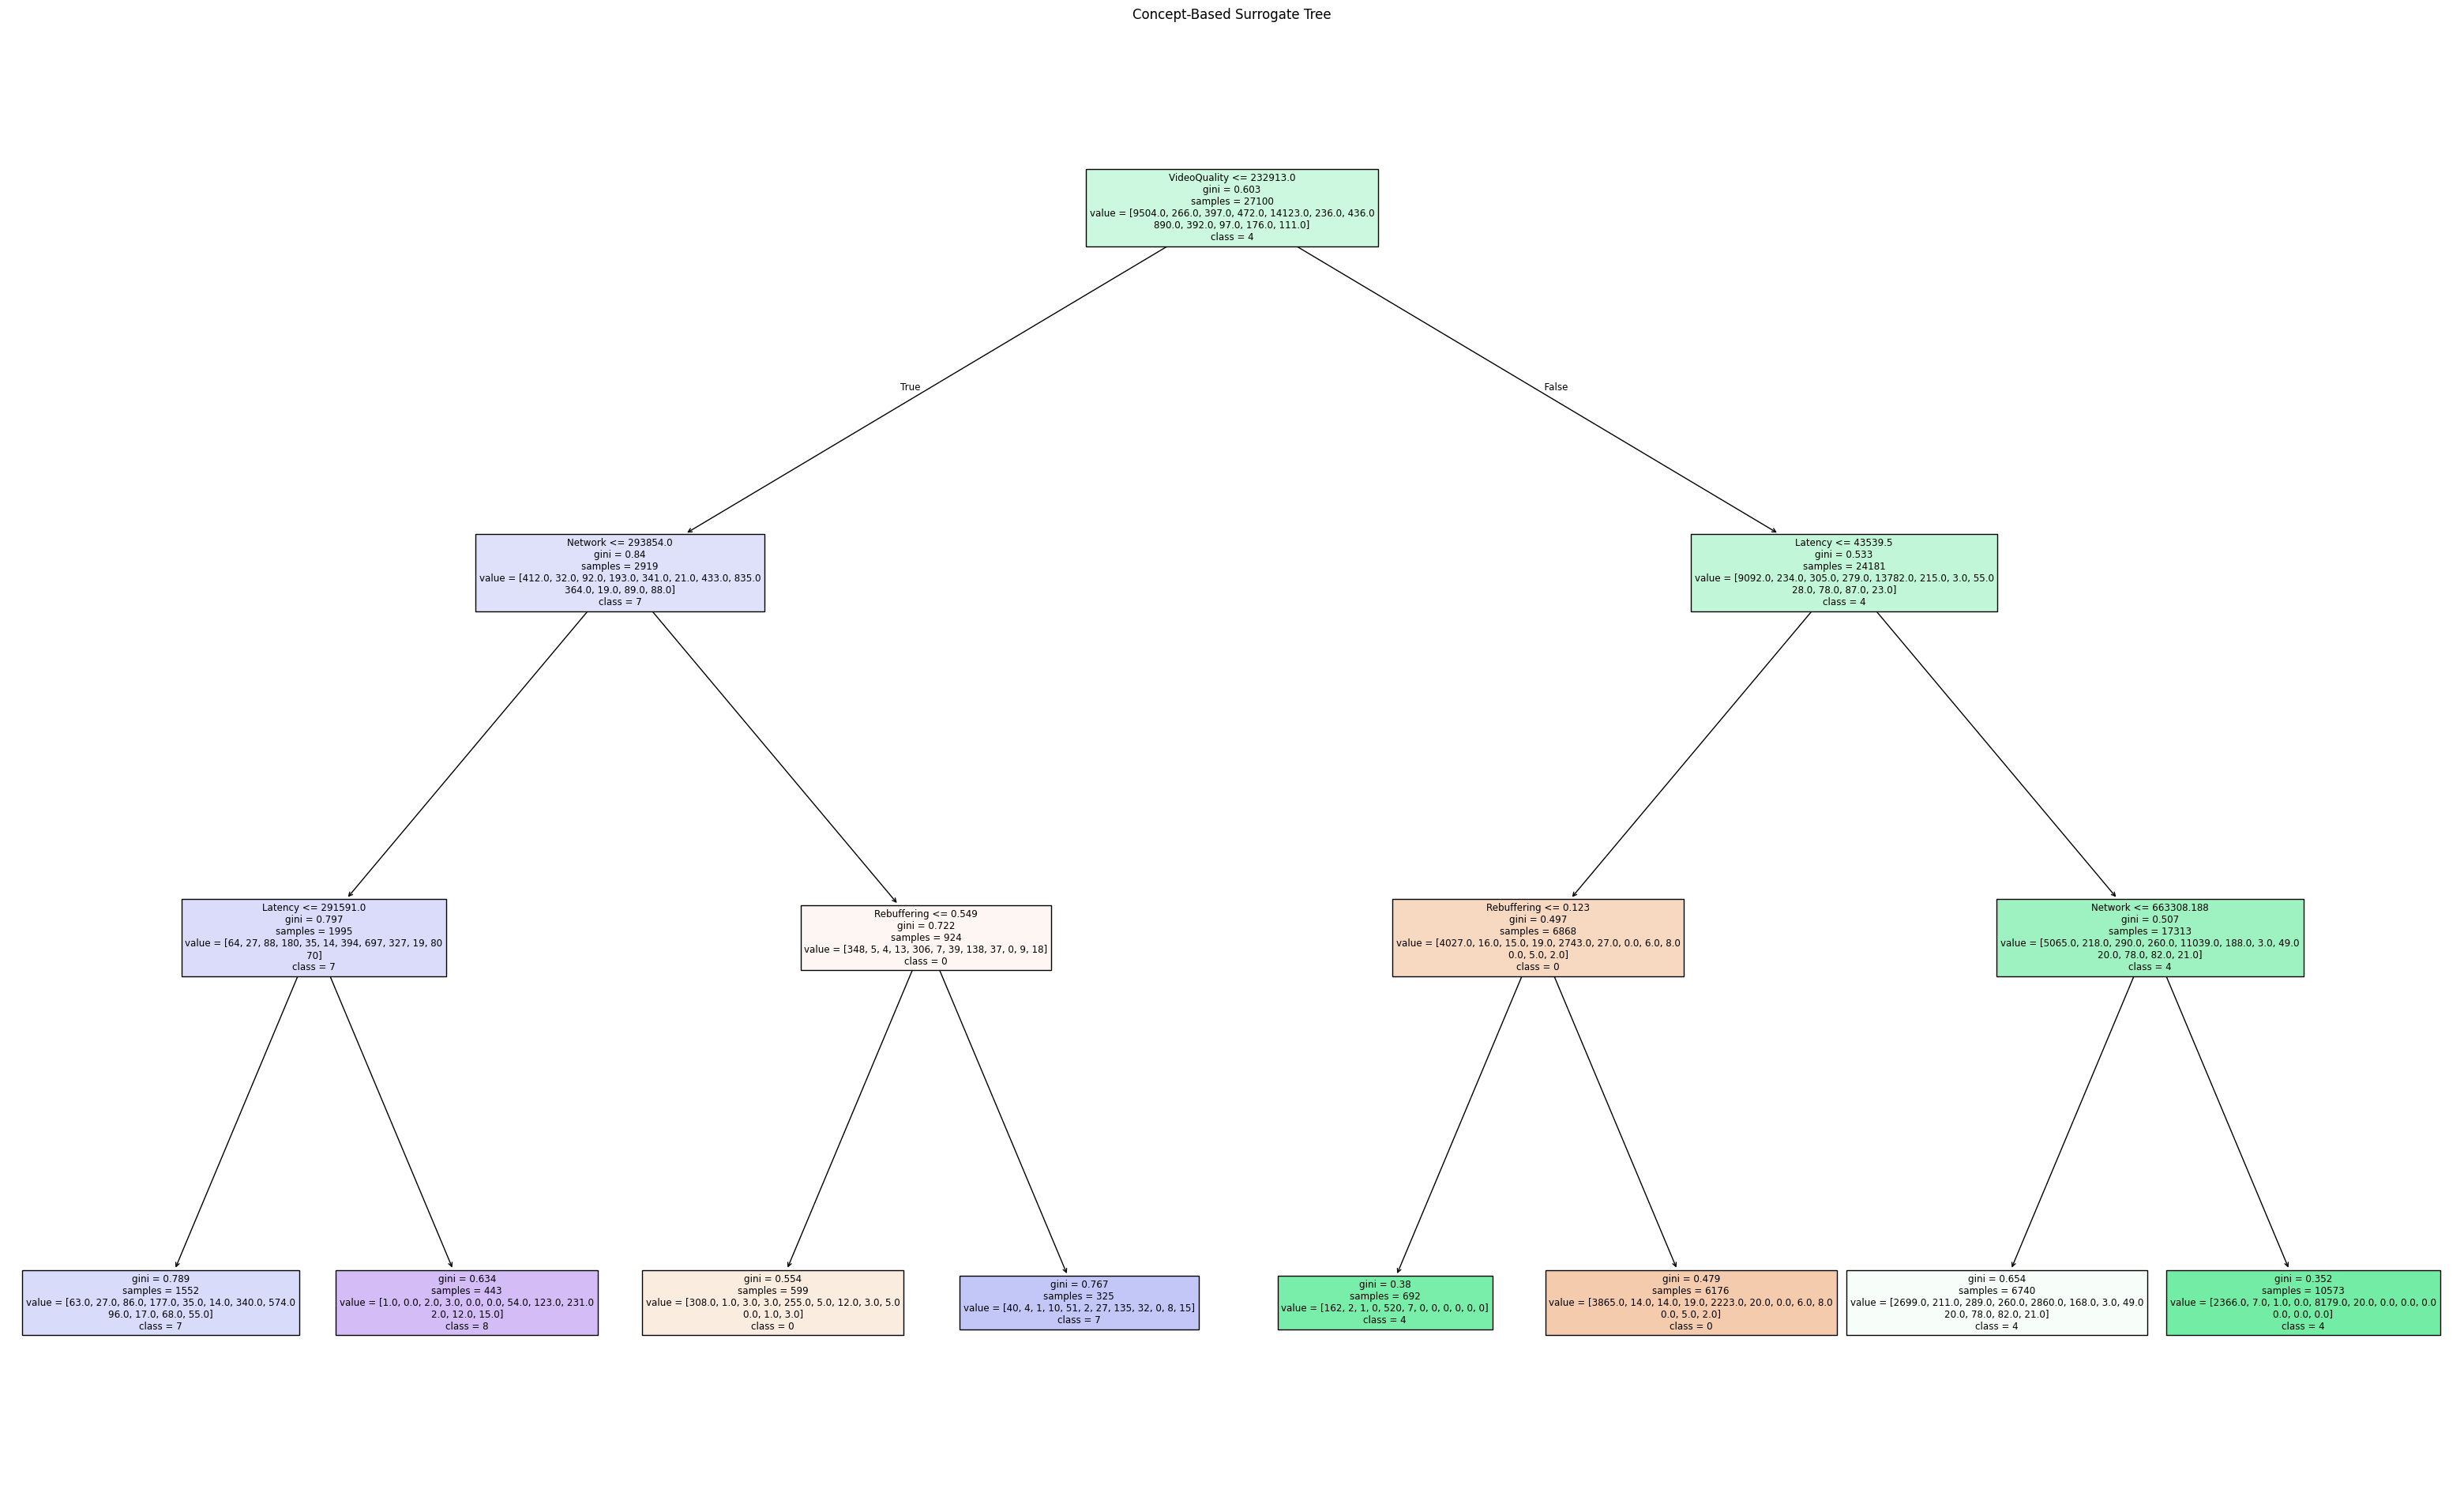

In [16]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Train a small decision tree on concept features
surrogate = DecisionTreeClassifier(max_depth=3, random_state=0)
surrogate.fit(X_test_concepts, y_test)

# Visualize the surrogate tree
plt.figure(figsize=(40, 24))
plot_tree(surrogate, 
          feature_names=X_test_concepts.columns, 
          filled=True, 
          class_names=[str(cls) for cls in sorted(y_test.unique())])
plt.title("Concept-Based Surrogate Tree")
plt.show()

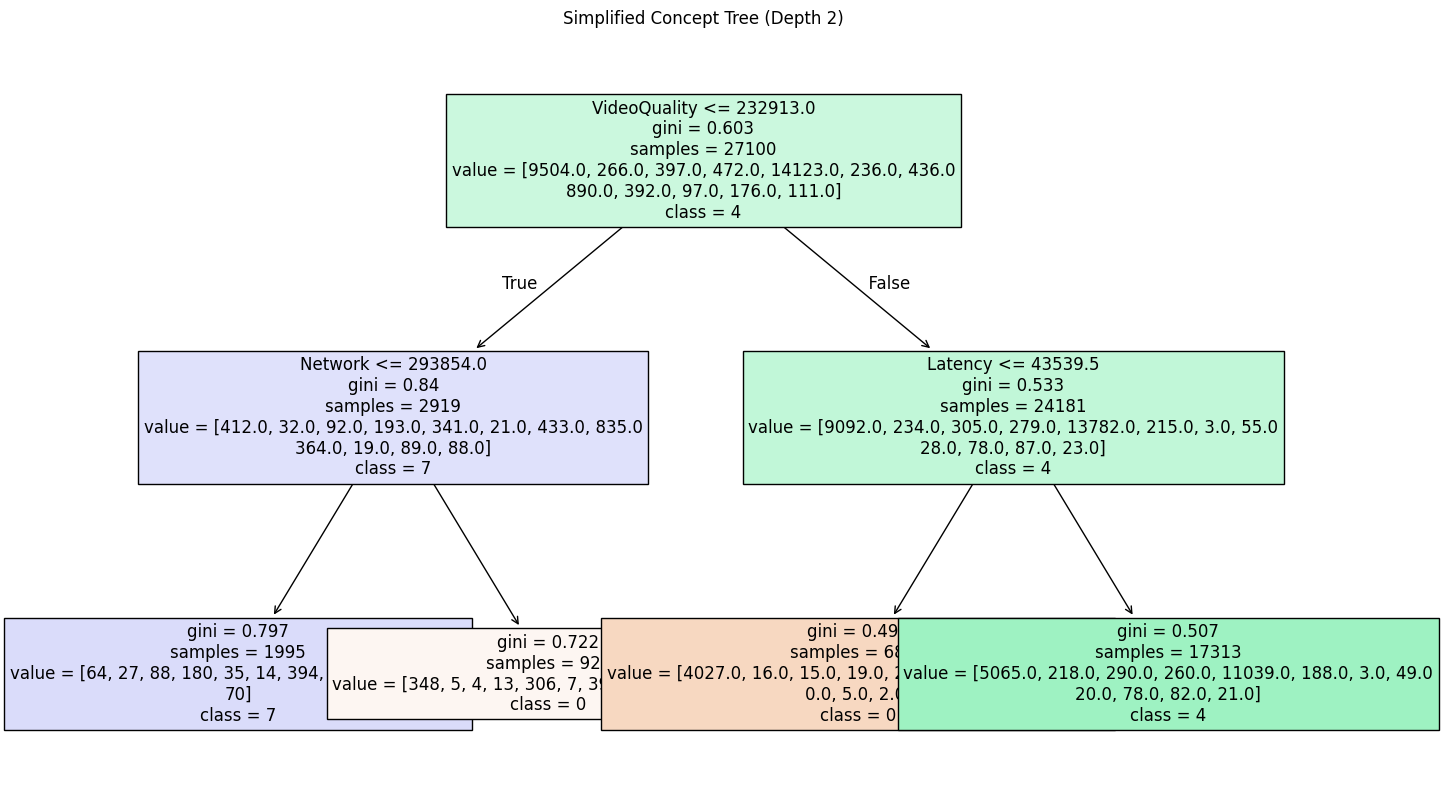

In [17]:
simpler_tree = DecisionTreeClassifier(max_depth=2, random_state=0)
simpler_tree.fit(X_test_concepts, y_test)

plt.figure(figsize=(16, 10))
plot_tree(
    simpler_tree,
    feature_names=X_test_concepts.columns,
    filled=True,
    class_names=[str(cls) for cls in sorted(y_test.unique())],
    fontsize=12
)
plt.title("Simplified Concept Tree (Depth 2)")
plt.show()

ExactExplainer explainer: 1001it [00:25, 23.83it/s]                             
/var/folders/d9/210kwmkj07x7qlhkkmmnw4z80000gn/T/ipykernel_12939/141469809.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values[:, :, 0], X_sample_df)


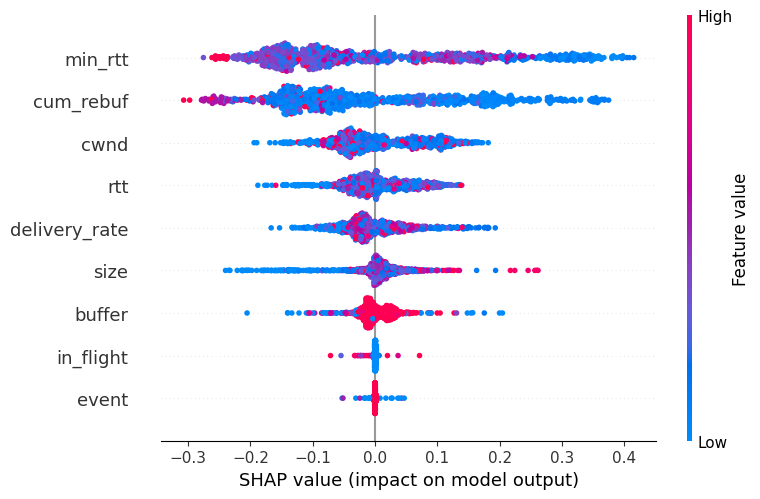

In [47]:
import shap

# Sample and DataFrame
X_sample = X_train[:1000]
X_sample_df = pd.DataFrame(X_sample, columns=[
    'size', 'cwnd', 'in_flight', 'min_rtt', 'rtt',
    'delivery_rate', 'event', 'buffer', 'cum_rebuf'
])

# Create SHAP explainer
explainer = shap.Explainer(clf.predict_proba, X_sample_df)
shap_values = explainer(X_sample_df)

# Summary plot for class index 0
shap.summary_plot(shap_values.values[:, :, 0], X_sample_df)